<h1 style = "text-align:center"> <u> Recipe Recommendation System </u></h1>


In [21]:
#Importing Libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import ast
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


# <a name = 'EDA' style="color:#000000;"> Exploratory Data Analysis and Data Preprocessing </a>

In [ ]:
#Loading the data
recipes_df = pd.read_csv("data/Model2Data/RAW_recipes.csv")
reviews_df = pd.read_csv("data/Model2Data/RAW_interactions.csv")

## <a name = Recipes style="color:#000000;"> Recipes Data </a>

In [23]:
recipes_df.shape

(231637, 12)

In [24]:
recipes_df.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13


In [25]:
#Checking unique values
print('The recipes dataset has', recipes_df['id'].nunique(), 'unique recipes.')

The recipes dataset has 231637 unique recipes.


The `nutrition` column shows the calories and the percentage daily value (PDV) for total fat, sugar, sodium, protein, saturated fat and carbohydrates respectively. We will split this information into individual columns. 

In [26]:
#Renaming ID -> Recipe_ID
recipes_df = recipes_df.rename(columns = {'id': 'recipe_id'})

#Nutrition values are evaluated as expression
recipes_df['nutrition'] = recipes_df['nutrition'].apply(eval)

#Distributing Values of Nutrition List to 7 New Detailed Columns
nutrition_columns = ['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']
recipes_df[nutrition_columns] = pd.DataFrame(recipes_df['nutrition'].tolist(), index = recipes_df.index)

#Removing Nutrition Column
recipes_df = recipes_df.drop(['nutrition'], axis=1)

#Dropping Duplicates
recipes_df = recipes_df.drop_duplicates()

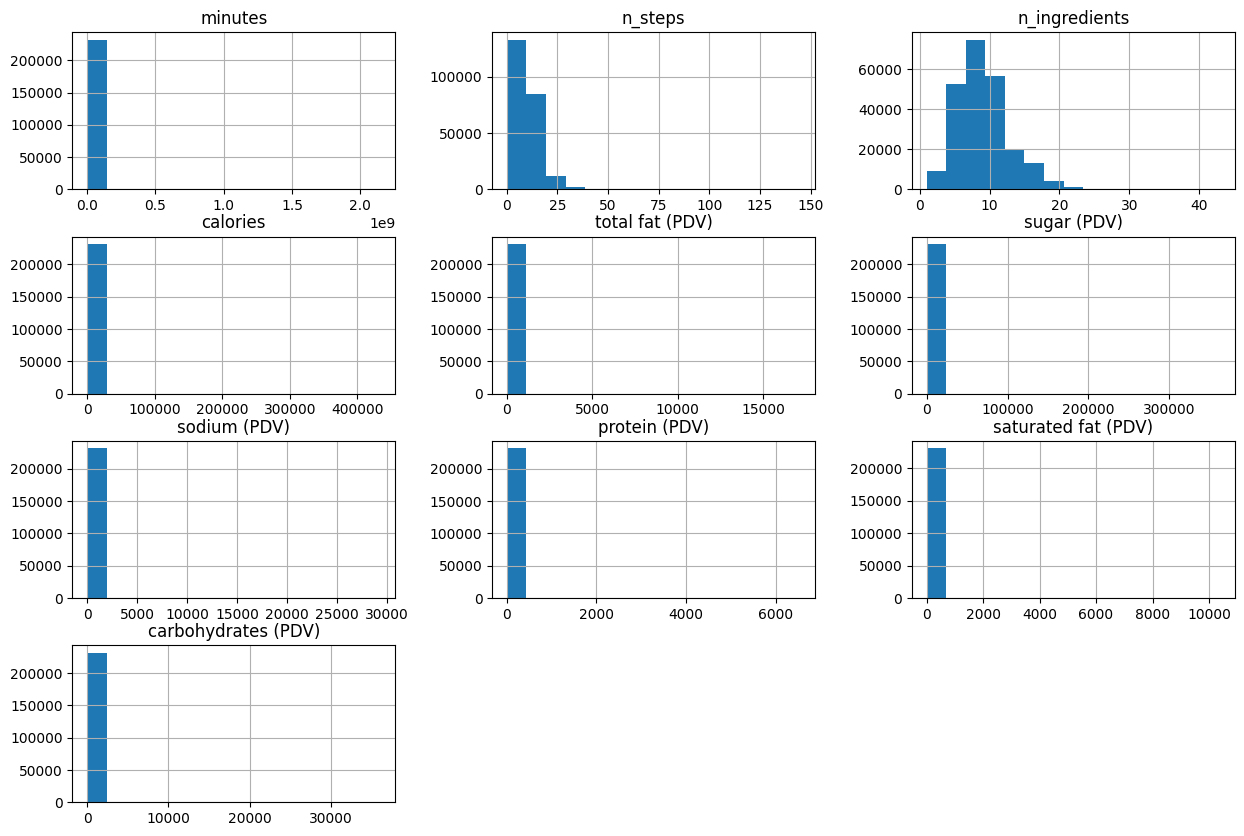

In [27]:
#Histograms for numerical features
recipes_df.drop(['recipe_id','contributor_id'], axis = 1).hist(bins = 15, figsize = (15, 10))
plt.show()

In [28]:
recipes_df.describe()

,recipe_id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,231637.000000,2.316370e+05,2.316370e+05,231637.000000,231637.000000,231637.000000,231637.00000,231637.000000,231637.000000,231637.00000,231637.000000,231637.000000
mean,222014.708984,9.398546e+03,5.534885e+06,9.765499,9.051153,473.942425,36.08070,84.296865,30.147485,34.68186,45.589150,15.560403
std,141206.635626,4.461963e+06,9.979141e+07,5.995128,3.734796,1189.711374,77.79884,800.080897,131.961589,58.47248,98.235758,81.824560
min,38.000000,0.000000e+00,2.700000e+01,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,99944.000000,2.000000e+01,5.690500e+04,6.000000,6.000000,174.400000,8.00000,9.000000,5.000000,7.00000,7.000000,4.000000
50%,207249.000000,4.000000e+01,1.736140e+05,9.000000,9.000000,313.400000,20.00000,25.000000,14.000000,18.00000,23.000000,9.000000
75%,333816.000000,6.500000e+01,3.982750e+05,12.000000,11.000000,519.700000,41.00000,68.000000,33.000000,51.00000,52.000000,16.000000
max,537716.000000,2.147484e+09,2.002290e+09,145.000000,43.000000,434360.200000,17183.00000,362729.000000,29338.000000,6552.00000,10395.000000,36098.000000


The maximum values for all the numerical columns (except `recipe_id`, `contributor_id`) appear to be unrealistically high. The minimum value for `minutes`, `n_steps` and `calories` is 0; this also seems infeasible and is causing the distributions to be skewed.  We will therefore remove any infeasible 0 values, including recipes where *all* of the nutrtion values are 0 (it is possible for some/any of these values to be 0, but not all simultaneously) and any observations that are more than 1.5 IQR above Q3 in each column (except `recipe_id` and `contributor_id`).

In [29]:
recipes_df_filtered = recipes_df.copy()

#Removing any rows where calories, minutes, n_ingredients, and n_steps are 0
recipes_df_filtered = recipes_df_filtered[(recipes_df_filtered['calories'] != 0) &
                                          (recipes_df_filtered['minutes'] != 0) &
                                          (recipes_df_filtered['n_steps'] != 0)]

#Removing the rows where all nutritional values are 0 simultaneously
recipes_df_filtered = recipes_df_filtered[(recipes_df_filtered[nutrition_columns] != 0).any(axis = 1)]

In [30]:
#Finding the numerical columns
numerical_columns = recipes_df.select_dtypes(include = ['number']).drop(['recipe_id','contributor_id'], axis = 1).columns.tolist()

#Calculating the 25th and 75th percentiles of all numerical columns to compute the IQR
Q1 = recipes_df_filtered[numerical_columns].quantile(0.25)
Q3 = recipes_df_filtered[numerical_columns].quantile(0.75)

#Calculating IQR for each column
IQR = Q3 - Q1

#Defining the upper limit as 1.5 times the IQR above Q3
upper_limit = Q3 + 1.5 * IQR

#Filtering out recipes with values above the upper limit for outlier handling
for col in numerical_columns:
    recipes_df_filtered = recipes_df_filtered[~(recipes_df_filtered[col] > upper_limit[col])]

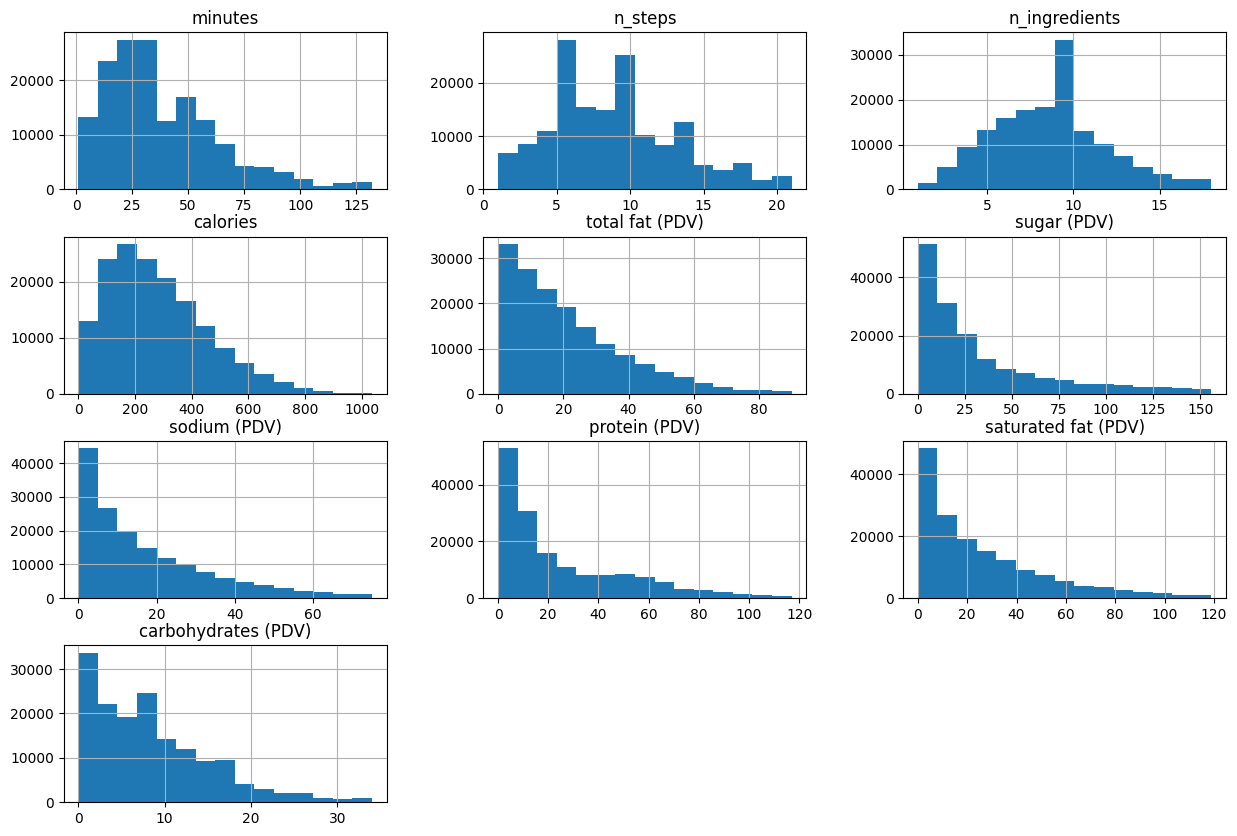

In [31]:
#Histograms for numerical features
recipes_df_filtered.drop(['recipe_id','contributor_id'], axis = 1).hist(bins = 15, figsize = (15, 10))
plt.show()

In [32]:
recipes_df_filtered.describe()

,recipe_id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,158826.000000,158826.000000,1.588260e+05,158826.000000,158826.000000,158826.000000,158826.000000,158826.000000,158826.000000,158826.000000,158826.000000,158826.000000
mean,225657.559531,37.667208,4.782267e+06,8.724963,8.635689,280.118173,20.610020,33.021363,16.678548,24.648175,25.339252,8.446722
std,139954.430947,25.562026,9.217519e+07,4.307644,3.297759,174.909059,17.714988,35.673637,16.425874,25.275568,25.366144,6.829841
min,45.000000,1.000000,2.700000e+01,1.000000,1.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,104812.500000,20.000000,5.810400e+04,6.000000,6.000000,144.600000,7.000000,8.000000,4.000000,5.000000,6.000000,3.000000
50%,213700.500000,30.000000,1.851050e+05,8.000000,8.000000,250.400000,16.000000,19.000000,11.000000,14.000000,17.000000,7.000000
75%,336501.750000,50.000000,4.149230e+05,11.000000,11.000000,385.200000,30.000000,46.000000,25.000000,39.000000,38.000000,12.000000
max,537716.000000,132.000000,2.002285e+09,21.000000,18.000000,1034.800000,90.000000,156.000000,75.000000,117.000000,119.000000,34.000000


In [33]:
recipes_df_filtered.shape

(158826, 18)

In [34]:
recipes_df_filtered.head(3)

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,269.8,22.0,32.0,48.0,39.0,27.0,5.0


In [35]:
print('The filtered recipes dataset has', recipes_df_filtered['recipe_id'].nunique(), 'unique recipes.')

The filtered recipes dataset has 158826 unique recipes.


## <a name = Reviews style="color:#000000;"> Reviews Data </a>

In [36]:
reviews_df.shape

(1132367, 5)

In [37]:
reviews_df.head(3)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...


In [38]:
#Checking unique values
print('The reviews dataset has', reviews_df['recipe_id'].nunique(), 'unique recipes,',
      reviews_df['user_id'].nunique(), 'unique users and', reviews_df['rating'].nunique(), 'unique ratings.')

The reviews dataset has 231637 unique recipes, 226570 unique users and 6 unique ratings.


In [39]:
reviews_df.describe()

,user_id,recipe_id,rating
count,1.132367e+06,1.132367e+06,1.132367e+06
mean,1.384291e+08,1.608972e+05,4.411016e+00
std,5.014269e+08,1.303987e+05,1.264752e+00
min,1.533000e+03,3.800000e+01,0.000000e+00
25%,1.354700e+05,5.425700e+04,4.000000e+00
50%,3.309370e+05,1.205470e+05,5.000000e+00
75%,8.045500e+05,2.438520e+05,5.000000e+00
max,2.002373e+09,5.377160e+05,5.000000e+00


The rating values of 0 represent where a recipe hasn't been rated. We will therefore remove these observations.

In [40]:
#Removing rows where rating is 0 (no rating)
reviews_df_filtered = reviews_df[reviews_df['rating'] != 0]

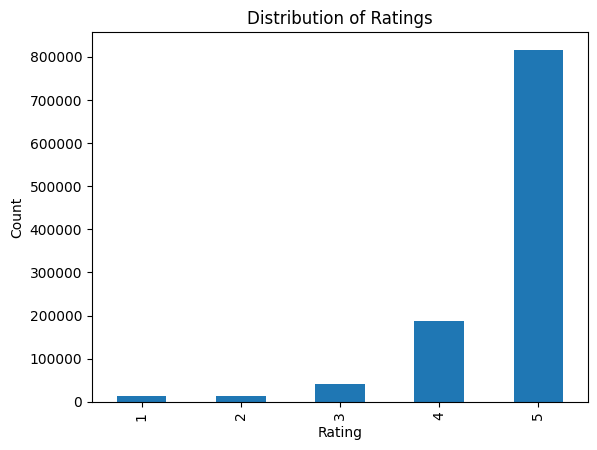

In [41]:
#Bar plot for the distribution of ratings
reviews_df_filtered['rating'].value_counts().sort_index().plot(kind = 'bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

The majority of recipes are given a rating of 5. 

In [42]:
print('The filtered reviews dataset has', reviews_df_filtered['recipe_id'].nunique(), 'unique recipes,',
      reviews_df_filtered['user_id'].nunique(), 'unique users and', 
      reviews_df_filtered['rating'].nunique(), 'unique ratings.')

The filtered reviews dataset has 226590 unique recipes, 196098 unique users and 5 unique ratings.


## <a name = 'Process Data for Knowledge Based Filtering' style="color:#000000;"> Process Data for Knowledge Based Filtering </a>

In [43]:
#Joining Pre-Processed Data with corresponding Review Data
merged_df = pd.merge(recipes_df_filtered, reviews_df_filtered, on = 'recipe_id', how = 'inner')

In [44]:
#Aggregating Ratings for each Recipe
agg_ratings_byrecipe = merged_df.groupby('recipe_id').agg(mean_rating = ('rating', 'mean'),
                                                          number_of_ratings = ('rating', 'count')).reset_index()

In [45]:
#Adding the average rating and number of rating to the filtered recipe data
KB_df = pd.merge(recipes_df_filtered, agg_ratings_byrecipe, on='recipe_id', how='inner')

In [46]:
KB_df.shape

(155806, 20)

In [47]:
KB_df.head(3)

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),mean_rating,number_of_ratings
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0,5.000000,3
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,173.4,18.0,0.0,17.0,22.0,35.0,1.0,4.666667,3
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,269.8,22.0,32.0,48.0,39.0,27.0,5.0,4.000000,1


In [48]:
#Converting all NaN to empty lists
KB_df['ingredients'] = KB_df['ingredients'].fillna('[]')

#Convert empty list string to object
KB_df['ingredients'] = KB_df['ingredients'].apply(literal_eval)

#Converting list to lowercase
KB_df['ingredients'] = KB_df['ingredients'].apply(lambda x: [ingredient.lower() for ingredient in x] if isinstance(x, list) else [])

#Creating new feature
s = KB_df.apply(lambda x: pd.Series(x['ingredients']), axis = 1).stack().reset_index(level = 1, drop = True)

#Renaming 'name' to 'ingredient'
s.name = 'ingredient'

#Joining s into KB_df
KB_df = KB_df.join(s)

In [49]:
KB_df.head(3)

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),mean_rating,number_of_ratings,ingredient
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,5.0,3,winter squash
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,5.0,3,mexican seasoning
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,5.0,3,mixed spice


In [50]:
KB_df.shape

(1345320, 21)

In [51]:
print('The knowledge base filtering dataset has', KB_df['recipe_id'].nunique(), 'unique recipes.')

The knowledge base filtering dataset has 155806 unique recipes.


## <a name = 'Process Data for Collaborative Filtering' style="color:#000000;"> Process Data for Collaborative Filtering </a>

In [52]:
#Counting the number of ratings for each recipe
recipes_numberofratings = reviews_df_filtered['recipe_id'].value_counts()

#Filtering Recipes with 20+ ratings
popular_recipes = recipes_numberofratings[recipes_numberofratings >= 20].index.tolist()

In [53]:
#Counting the number of recipes rated by each user
users_numberofratings = reviews_df_filtered['user_id'].value_counts()

#Filtering Recipes with 20+ ratings
active_users = users_numberofratings[users_numberofratings >= 20].index.tolist()

In [54]:
#Only keeping observations where the recipe has 20+ rating and the user has rated 20+ recipes
reviews_df_filteredforCF = reviews_df_filtered[reviews_df_filtered['recipe_id'].isin(popular_recipes) &
                                reviews_df_filtered['user_id'].isin(active_users)]

In [55]:
#Joining recipes_df_filtered and reviews_df_filteredforCF
CF_df = pd.merge(recipes_df_filtered, reviews_df_filteredforCF, on = 'recipe_id', how = 'inner')

In [56]:
#Joining agg_ratings_byrecipe so the dataset includes mean rating and number of rating per recipe
CF_df = pd.merge(CF_df, agg_ratings_byrecipe, on = 'recipe_id', how = 'inner')

In [57]:
CF_df.shape

(152009, 24)

In [58]:
CF_df.head(3)

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),user_id,date,rating,review,mean_rating,number_of_ratings
0,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","['frozen chopped spinach', 'egg', 'salt', 'bla...",...,32.0,19.0,26.0,3.0,112080,2006-12-15,4,The recipe was good but too salty. I agree wi...,4.342593,108
1,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","['frozen chopped spinach', 'egg', 'salt', 'bla...",...,32.0,19.0,26.0,3.0,29956,2002-04-23,3,"It was alright, but won't be rushing out to ma...",4.342593,108
2,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","['frozen chopped spinach', 'egg', 'salt', 'bla...",...,32.0,19.0,26.0,3.0,57828,2002-12-01,4,Great way to make spinach that doesn't taste t...,4.342593,108


In [59]:
print('The collaborative filtering dataset has', CF_df['recipe_id'].nunique(), 'unique recipes and',
      CF_df['user_id'].nunique(), 'unique users.')

The collaborative filtering dataset has 5008 unique recipes and 6419 unique users.


## <a name = 'Process Data for Content Based Filtering' style="color:#000000;">Process Data for Content Based Filtering </a>

In [60]:
#Using the same recipes from the collaborative filtering dataset, but removing the reviews/ratings related data
CB_df = CF_df.drop(['user_id','date','rating','review'], axis = 1).drop_duplicates()

In [61]:
CB_df.head(3)

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),mean_rating,number_of_ratings
0,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","['frozen chopped spinach', 'egg', 'salt', 'bla...",8,166.1,16.0,6.0,32.0,19.0,26.0,3.0,4.342593,108
51,immoral sandwich filling loose meat,58224,35,37183,2003-04-04,"['60-minutes-or-less', 'time-to-make', 'course...",6,"['brown the meat & drain fat', 'stir in sugar ...",just the thing for a day when you're wanton so...,"['ground beef', 'sugar', 'prepared yellow must...",8,223.2,22.0,4.0,7.0,35.0,30.0,0.0,4.200000,20
67,land of nod cinnamon buns,22526,35,29212,2002-03-14,"['60-minutes-or-less', 'time-to-make', 'course...",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,"['rolls', 'brown sugar', 'instant vanilla pudd...",6,575.3,18.0,116.0,34.0,28.0,22.0,34.0,4.734694,49


In [62]:
CB_df.shape

(5008, 20)

In [ ]:
print('The content based filtering dataset has', CB_df['recipe_id'].nunique(), 'unique recipes.')

NameError: name 'CB_df' is not defined

# <a name = 'Content Based Filtering' style="color:#000000;">Content Based Filtering </a>

In [64]:
def CB_recommendations(CB_df, recipe_id, num_recs):
    text_data = CB_df['steps'].tolist()
    
    #Creating TfidfVectorizer object
    tfidf = TfidfVectorizer()
    
    #Computing sparse matrix with words
    tfidf_matrix = tfidf.fit_transform(text_data)
    
    recipe = recipes_df.loc[recipes_df['recipe_id'] == recipe_id]
    ingredients = recipe['ingredients'].values[0] if isinstance(recipe['ingredients'].values[0], list) else ast.literal_eval(recipe['ingredients'].values[0])
    ingredients_str = ', '.join(ingredients)
    
    #Computing TF-IDF matrix
    new_query = ingredients_str
    new_query_vector = tfidf.transform([new_query])

    #Computing cosine similarity
    cosine_sim = pd.DataFrame(cosine_similarity(tfidf_matrix, new_query_vector), columns = ['cosine_similarity_score'], index = CB_df.index)

    #Ranking cosine similarity - desciending
    cosine_sim = cosine_sim.sort_values(by = ['cosine_similarity_score'], ascending = False)

    recipe_recomm = CB_df.loc[cosine_sim.index[1: num_recs + 1],:]
    return recipe_recomm

In [65]:
#Generating a random recipe_id
recipe_id = recipes_df_filtered.recipe_id.sample().tolist()[0]
recipes_df_filtered[recipes_df_filtered['recipe_id']==recipe_id]

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
94068,gomiti rigati con piselli,475083,25,1620171,2012-02-26,"['30-minutes-or-less', 'time-to-make', 'course...",4,"['heat the olive oil in a pot , add the onions...",taken from = http://italianfood.about.com/od/p...,"['elbow macaroni', 'shelled peas', 'onions', '...",6,565.1,23.0,47.0,0.0,36.0,11.0,29.0


In [66]:
CB_recommendations(CB_df, recipe_id, 5)

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),mean_rating,number_of_ratings
105592,peas amandine,28383,20,37305,2002-05-13,"['30-minutes-or-less', 'time-to-make', 'course...",4,['cook peas according to package directions an...,we love green beans amandine and figured we wo...,"['frozen peas', 'slivered almonds', 'butter', ...",7,103.3,9.0,12.0,7.0,7.0,14.0,2.0,4.954545,22
48449,dressed peas,14953,20,4470,2001-11-28,"['30-minutes-or-less', 'time-to-make', 'course...",6,['heat and mix all the sauce ingredients in a ...,"this recipe is from ""company's coming for chri...","['water', 'cornstarch', 'red wine vinegar', 's...",10,68.7,0.0,18.0,6.0,8.0,0.0,4.0,4.437500,48
110382,poverty meal,27520,25,15851,2002-05-07,"['30-minutes-or-less', 'time-to-make', 'course...",6,['saute onions and garlic in olive oil until t...,"when i was a child, my family used to eat this...","['onion', 'garlic cloves', 'olive oil', 'groun...",10,578.7,33.0,47.0,26.0,63.0,36.0,21.0,4.446581,468
137652,the lady s macaroni and cheese paula deen,55556,65,44160,2003-03-04,"['weeknight', 'time-to-make', 'course', 'main-...",5,"['preheat oven to 350f', 'once you have the ma...",i saw this recipe on paula's home cooking on t...,"['elbow macaroni', 'cheddar cheese', 'eggs', '...",7,578.1,44.0,11.0,23.0,46.0,84.0,18.0,4.316667,60
37342,cold macaroni tuna salad,26085,90,37779,2002-04-22,"['weeknight', 'time-to-make', 'course', 'main-...",8,['cook macaroni according to package direction...,this is the answer for me on a hot summer day....,"['hard-boiled eggs', 'macaroni', 'frozen green...",7,574.4,15.0,36.0,15.0,83.0,13.0,25.0,4.741935,31


# <a name = 'Knowledge Based Filtering (with Content-Based Integrated)' style="color:#000000;"> Knowledge Based Filtering (with Content-Based Integrated) </a>

In [67]:
def knowledge_based(KB_df, percentile = 0.8):
    
    #Series of questions to ask the user their preferences 
    ingredients_preference = get_boolean_preference("\nDo you have a preference on ingredients? (yes/no):")
    preferred_ingredients = None
    include_all_ingredients = False

    if ingredients_preference == 'yes':
        preferred_ingredients = get_preferred_ingredients()
        include_all_ingredients = get_boolean_preference("\nShould the recipes include all of these ingredients? (yes/no):")

    matching_recipes = filter_recipes_by_ingredients(KB_df, preferred_ingredients, include_all_ingredients)
    
    time_limited = get_boolean_preference("\nAre you limited for time? (yes/no):")
    
    max_time = None
    if time_limited == 'yes':
        max_time = get_numeric_preference("\nHow long do you have in minutes?", "\nInvalid input. Please enter a valid numerical value for time.")
    
    cals_limited = get_boolean_preference("\nWould you like to limit calorie intake? (yes/no):")
    
    max_cals = None
    if cals_limited == 'yes':
        max_cals = get_numeric_preference("\nWhat is your maximum preferred calories?", "\nInvalid input. Please enter a valid numerical value for calories.")

    preference = get_user_preference("\nWould you prefer a recipe with: \n1. fewer steps \n2. fewer ingredients \n3. less time required \n4. the highest rating \n5. lower calories \n6. higher calories \n7. specific nutritional preferences? \nPlease select from options 1-7 (enter the number):", ['1', '2', '3', '4', '5', '6', '7'])
    
    filters = [('time', max_time), ('calories', max_cals)]
    recipes = apply_filters(matching_recipes, max_time, max_cals)
    
    if preference == '7':
        print("\nEnter your specific nutritional preferences, separated by commas (e.g. sodium (low), protein (high)).\nYou can choose from: \n-total fat \n-saturated fat \n-sugar \n-sodium \n-protein \n-carbohydrates")
        nutritional_preferences = input().lower().split(',')
        recommendations = calculate_and_sort_scores(recipes, KB_df['number_of_ratings'].quantile(percentile), percentile, preference, nutritional_preferences)
    else:
        recommendations = calculate_and_sort_scores(recipes, KB_df['number_of_ratings'].quantile(percentile), percentile, preference)
    

    if not recommendations.empty:
        recommendations = recommendations.drop_duplicates(subset=['recipe_id']).copy()
        num_recommendations = get_num_recommendations()    
        display_recommendations(recommendations, num_recommendations)
        # Ask the user if they want to see a recipe in more detail
        user_option = get_user_preference("\nWould you like to:\n1. see a recipe in more detail\n2. see recipes similar to one of the recommendations \n3. Quit \nPlease select option 1, 2 or 3:", ['1', '2', '3'])

        if user_option == '1':
            recipe_id = get_numeric_preference("\nEnter the recipe ID:")
            display_single_recipe(recipe_id, KB_df)
            user_pref = get_boolean_preference("\nWould you like to see recipes similar to this? (yes/no):")
            if user_pref == 'yes':
                CB_result = CB_recommendations(CB_df, recipe_id, 5)
                display_recommendations(CB_result, 5)
        elif user_option == '2':
            recipe_id = get_numeric_preference("\nEnter the recipe ID to see similar recipes:")
            CB_result = CB_recommendations(CB_df, recipe_id, 5)
            display_recommendations(CB_result, 5)
            user_pref = get_boolean_preference("\nWould you like to see a recipe in more detail? (yes/no):")
            if user_pref == 'yes':
                recipe_id = get_numeric_preference("\nEnter the recipe ID:")
                display_single_recipe(recipe_id, CF_df)
            else:
                print('We hope you like our recommendations!')             
        else:
            print('We hope you like our recommendations!')
    else:
        print("\nSorry, we couldn't find you any recommendations.")
        
        
#Asking user for their preferences - ensuring validity of respose        
def get_user_preference(prompt, valid_responses):
    while True:
        print(prompt)
        response = input().lower()
        if response in valid_responses:
            return response
        else:
            print(f"\nInvalid response. Please enter one of: {', '.join(valid_responses)}")

#Asking user for prefered ingredients
def get_preferred_ingredients():
    print("\nPlease enter preferred ingredients separated by commas (e.g., ingredient1,ingredient2):")
    return [ingredient.strip() for ingredient in input().lower().split(',')]

#Asking for yes/no response
def get_boolean_preference(prompt):
    return get_user_preference(prompt, ['yes', 'no'])

#Asking for numeric response
def get_numeric_preference(prompt, error_message="\nInvalid input. Please enter a valid numerical value."):
    while True:
        try:
            print(prompt)
            return int(input())
        except ValueError:
            print(error_message)

#Asking how many preferred recomendations user desires
def get_num_recommendations():
    num_recs = get_numeric_preference("\nWhat is the maximum number of recommendations you'd like to receive? Enter a numerical value:", "Invalid input. Please enter a valid numerical value for the number of recommendations.")
    return num_recs

#Filtering recipe based on ingredients - KB
def filter_recipes_by_ingredients(KB_df, preferred_ingredients, include_all_ingredients):
    if preferred_ingredients:
        if not include_all_ingredients:
            matching_recipes = KB_df[KB_df['ingredients'].apply(
                lambda x: any(ingredient in set(map(str.strip, x)) for ingredient in preferred_ingredients)
            )]
        else:
            matching_recipes = KB_df[KB_df['ingredients'].apply(
                lambda x: set(preferred_ingredients).issubset(set(map(str.strip, x)))
            )]

        if not matching_recipes.empty:
            return matching_recipes

        print("\nNo recipes found with all specified ingredients.")
        include_at_least_one = get_boolean_preference("\nAre you okay with recommendations that only include some of your preferred ingredients? (yes/no):")
        if include_at_least_one == 'yes':
            matching_recipes = KB_df[KB_df['ingredients'].apply(
                lambda x: any(ingredient in set(map(str.strip, x)) for ingredient in preferred_ingredients)
            )]
            return matching_recipes

        return pd.DataFrame()
    else:
        return KB_df.copy()

#Applying filter on minutes and calories
def apply_filters(KB_df, max_time = None, max_cals = None):
    if max_time:
        KB_df = KB_df[KB_df['minutes'] <= max_time]
    if max_cals:
        KB_df = KB_df[KB_df['calories'] <= max_cals]
    return KB_df

#Calculating and sorting score per recipe
def calculate_and_sort_scores(KB_df, m, percentile, preference, nutritional_preferences=None):
    C = KB_df['mean_rating'].mean()
    q_recipes = KB_df.loc[KB_df['number_of_ratings'] >= m]

    if not q_recipes.empty:
        q_recipes = q_recipes.copy()
        q_recipes['score'] = q_recipes.apply(lambda x: calculate_score(x, C, m, preference, nutritional_preferences), axis=1)
        q_recipes = q_recipes.sort_values('score', ascending=False)
        return q_recipes
    else:
        print("\nNo recipes found based on the specified criteria.")
        return pd.DataFrame()

#Calculating score based on resipe and preferences
def calculate_score(recipe, C, m, preference, nutritional_preferences=None):
    if preference == '1':
        return -recipe['n_steps'] + (recipe['number_of_ratings'] / (recipe['number_of_ratings'] + m) * recipe['mean_rating']) + (m / (m + recipe['number_of_ratings']) * C)
    elif preference == '2':
        return -recipe['n_ingredients'] + (recipe['number_of_ratings'] / (recipe['number_of_ratings'] + m) * recipe['mean_rating']) + (m / (m + recipe['number_of_ratings']) * C)
    elif preference == '3':
        return -recipe['minutes'] + (recipe['number_of_ratings'] / (recipe['number_of_ratings'] + m) * recipe['mean_rating']) + (m / (m + recipe['number_of_ratings']) * C)
    elif preference == '4':
        return (recipe['number_of_ratings'] / (recipe['number_of_ratings'] + m) * recipe['mean_rating']) + (m / (m + recipe['number_of_ratings']) * C)
    elif preference == '5':
        return -recipe['calories'] + (recipe['number_of_ratings'] / (recipe['number_of_ratings'] + m) * recipe['mean_rating']) + (m / (m + recipe['number_of_ratings']) * C)
    elif preference == '6':
        return recipe['calories'] + (recipe['number_of_ratings'] / (recipe['number_of_ratings'] + m) * recipe['mean_rating']) + (m / (m + recipe['number_of_ratings']) * C)
    elif preference == '7':
        
        return calculate_nutritional_score(recipe, C, m, nutritional_preferences)
    else:
        return 0

#Calculating nutrional score
def calculate_nutritional_score(recipe, C, m, nutritional_preferences):
    score = 0
    for pref in nutritional_preferences:
        nutrient, condition = [part.strip() for part in pref.split('(')]
        condition = condition[:-1]
        column_name = f"{nutrient} (PDV)"
        if column_name in recipe.index:
            if condition == 'low':
                score += -recipe[column_name] + (recipe['number_of_ratings'] / (recipe['number_of_ratings'] + m) * recipe['mean_rating']) + (m / (m + recipe['number_of_ratings']) * C)
            elif condition == 'high':
                score += recipe[column_name] + (recipe['number_of_ratings'] / (recipe['number_of_ratings'] + m) * recipe['mean_rating']) + (m / (m + recipe['number_of_ratings']) * C)
        else:
            print(f"\nNutrient '{column_name}' not found. Ignoring nutritional preference.")
            break
    return score

#Displaying recipe formatting
def display_single_recipe(recipe_id, df):
    #Locating the specific recipe
    recipe = df.loc[df['recipe_id'] == recipe_id]

    if not recipe.empty:
        #Removing uneeded info
        title = recipe['name'].values[0]
        ingredients = recipe['ingredients'].values[0] if isinstance(recipe['ingredients'].values[0], list) else ast.literal_eval(recipe['ingredients'].values[0])
        time = recipe['minutes'].values[0]
        nutritional_info = get_nutritional_info(recipe)
        method = format_recipe_steps(recipe['steps'].values[0])

        #Displaying info using print statements
        print(f"\nRecipe: {title}\n")
        print("Ingredients:")
        for ingredient in ingredients:
            print(f"- {ingredient}")
        print(f"\nTime: {time} minutes\n")
        print("Nutritional Information:")
        print(nutritional_info)
        print("\nMethod:")
        print(method)
    else:
        print(f"\nNo recipe found with the given ID: {recipe_id}")

#Formatting recipe
def format_recipe_steps(steps):
    steps_list = ast.literal_eval(steps)
    formatted_steps = "\n".join([f"Step {i+1}: {step}" for i, step in enumerate(steps_list)])
    return formatted_steps

#Getting nutritional information
def get_nutritional_info(recipe):
    calories = recipe['calories'].values[0]
    total_fat_pdv = recipe['total fat (PDV)'].values[0]
    sugar_pdv = recipe['sugar (PDV)'].values[0]
    sodium_pdv = recipe['sodium (PDV)'].values[0]
    protein_pdv = recipe['protein (PDV)'].values[0]
    saturated_fat_pdv = recipe['saturated fat (PDV)'].values[0]
    carbohydrates_pdv = recipe['carbohydrates (PDV)'].values[0]

    #Formatting
    table = f"Calories: {calories}\n" \
            f"Total Fat (PDV): {total_fat_pdv}\n" \
            f"Sugar (PDV): {sugar_pdv}\n" \
            f"Sodium (PDV): {sodium_pdv}\n" \
            f"Protein (PDV): {protein_pdv}\n" \
            f"Saturated Fat (PDV): {saturated_fat_pdv}\n" \
            f"Carbohydrates (PDV): {carbohydrates_pdv}"

    return table

#Displaying recomendations
def display_recommendations(recommendations, num_recommendations):
    if not recommendations.empty:
        recommendations.loc[:, 'ingredients'] = recommendations['ingredients'].astype(str)
        display_cols = ['name','recipe_id','minutes','steps','ingredients','calories','total fat (PDV)','sugar (PDV)','sodium (PDV)','protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)', 'mean_rating', 'number_of_ratings']
        recommendations = recommendations[display_cols].head(num_recommendations)
        max_colwidth = len(max(recommendations['ingredients'], key=len))
        pd.set_option('display.max_colwidth', max_colwidth)    
        display(recommendations)

In [69]:
knowledge_based(KB_df, percentile = 0.8)


Do you have a preference on ingredients? (yes/no):

Please enter preferred ingredients separated by commas (e.g., ingredient1,ingredient2):

Should the recipes include all of these ingredients? (yes/no):

Are you limited for time? (yes/no):

How long do you have in minutes?

Would you like to limit calorie intake? (yes/no):

Would you prefer a recipe with: 
1. fewer steps 
2. fewer ingredients 
3. less time required 
4. the highest rating 
5. lower calories 
6. higher calories 
7. specific nutritional preferences? 
Please select from options 1-7 (enter the number):

What is the maximum number of recommendations you'd like to receive? Enter a numerical value:


,name,recipe_id,minutes,steps,ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),mean_rating,number_of_ratings
26536,cheese filling for ravioli,16445,5,['mix together all ingredients well and fill pasta'],"['ricotta cheese', 'parmesan cheese', 'parsley', 'egg', 'salt', 'nutmeg', 'pasta dough']",123.8,13.0,0.0,9.0,17.0,27.0,0.0,4.714286,7
84065,low carb chocolate mug cake,470501,7,"['mix everything together in a big mug or small bowl and put it in the microwave for 90 seconds maybe 10 more seconds after that depends on your microwave and enjoy it , yu...","['almond meal', 'splenda sugar substitute', 'unsweetened cocoa powder', 'coconut oil', 'cream', 'vanilla extract', 'egg']",437.0,59.0,28.0,3.0,21.0,114.0,4.0,4.600000,10
152955,winter snow cream,36085,10,"['mix all ingredients except snow', 'add snow and stir til desired thickness']","['egg', 'milk', 'vanilla extract', 'sugar', 'snow']",77.7,3.0,40.0,1.0,4.0,6.0,4.0,4.857143,7
154263,yorkshire spice bread for the a b m,103186,10,"[""bake bread according to bread machine manufacturer's directions"", 'add walnuts and raisins at the beginning of the fruit / nut beep cycle']","['active dry yeast', 'cinnamon', 'unbleached flour', 'nutmeg', 'orange, zest of', 'powdered sugar', 'egg', 'cooking oil', 'butter', 'maple syrup', 'milk', 'raisins', 'walnu...",614.4,29.0,115.0,5.0,25.0,40.0,32.0,4.833333,6
80504,leftover stuffing balls,223436,10,"['mix all ingredients together and form into balls', 'place on a greased baking sheet and bake at 350f for about 8 minutes or until warmed and ""set""']","['prepared stuffing', 'egg', 'vegetables', 'cheese']",194.9,15.0,8.0,22.0,9.0,10.0,7.0,4.800000,5
55896,fish chicken batter,103054,5,"['add all ingredients into a mixing bowl', 'mix well']","['flour', 'cornstarch', 'baking soda', 'baking powder', 'salt', 'water', 'egg']",134.0,2.0,0.0,21.0,8.0,2.0,8.0,4.571429,7
68147,hamburger budget stretch,136773,5,"['mix and season to taste', 'alma\'s recipe called for ""some"" onion , so use however much you\'d like']","['hamburger', 'oatmeal', 'onion', 'egg']",263.0,17.0,2.0,2.0,42.0,19.0,6.0,4.400000,5
493,1 1 1 tempura batter,164636,5,"['mix all ingredients together with whisk until smooth', 'dip your favorite food for frying , remove and fry the food in hot grease']","['egg', 'flour', 'water']",526.5,9.0,2.0,3.0,38.0,8.0,31.0,4.285714,14
131,leftover lo mein for two,221049,9,"['combine everything but pasta on stove top and heat until bubbling', 'add pasta and serve']","['cooked pasta', 'carrots', 'peas', 'egg', 'cooked chicken', 'soy sauce', 'chicken broth']",302.6,9.0,8.0,18.0,36.0,8.0,14.0,4.222222,9
39599,cottage cheese pancakes bisquick,237624,8,"['combine all ingredients in a bowl', 'cook like regular pancakes in a greased skillet , flipping once - mind the cheese , it melts and sticks sometimes', 'serve with syrup...","['egg', 'cottage cheese', 'bisquick']",155.7,10.0,13.0,16.0,20.0,11.0,4.0,5.000000,6



Would you like to:
1. see a recipe in more detail
2. see recipes similar to one of the recommendations 
3. Quit 
Please select option 1, 2 or 3:
We hope you like our recommendations!
